# Response Quality Evaluation

This notebook evaluates the quality of generated responses using RAGAS metrics and conversational quality assessment.

**Objectives:**
1. Test response generation with real patient scenarios
2. Measure RAGAS metrics (faithfulness, relevance, etc.)
3. Assess conversational quality
4. Compare old vs new system responses

In [1]:
import sys
import os
sys.path.append('../')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..')))
from app.services.ragas_evaluator import RAGASEvaluator, format_evaluation_report
from app.core.alzheimer_rag_system import AlzheimerRAGSystem, UserType, PatientContext
from app.config import GEN_MODEL_NAME
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

## 1. Initialize Components

In [2]:

rag = AlzheimerRAGSystem()


evaluator = RAGASEvaluator()

print(" All components initialized")


ENHANCED AGENTIC RAG SYSTEM v3.2 - OPTIMIZED WITH FORMATTING
🔧 Initializing Enhanced Retriever with Knowledge Graph...
✓ Knowledge graph initialized
✓ Model loaded on cpu
✓ Loaded 10090 document chunks
System initialized successfully!

 All components initialized


## 2. Test Scenarios with Patient Context

In [3]:
# Define realistic test scenarios
test_scenarios = [
    {
        'query': 'What do you think about this patient?',
        'patient_context': {
            'age': 66,
            'mmse_score': 25,
            'moca_score': 27,
            'symptoms': ['mild memory lapses'],
            'biomarkers': {'amyloid': 'unknown', 'tau': 'unknown'}
        },
        'user_type': 'doctor',
        'expected_qualities': ['personalized', 'uses scores', 'professional tone']
    },
    {
        'query': "Why did you say she may have early-stage Alzheimer's?",
        'patient_context': {
            'age': 66,
            'mmse_score': 25,
            'moca_score': 27
        },
        'user_type': 'doctor',
        'expected_qualities': ['explains reasoning', 'references scores', 'not generic']
    },
    {
        'query': "What are early symptoms of Alzheimer's?",
        'patient_context': None,
        'user_type': 'patient',
        'expected_qualities': ['conversational', 'supportive', 'clear']
    },
    {
        'query': 'Thank you',
        'patient_context': None,
        'user_type': 'patient',
        'expected_qualities': ['brief', 'natural', 'not generic']
    },
    {
        'query': 'How can I support my mother with memory problems?',
        'patient_context': None,
        'user_type': 'caregiver',
        'expected_qualities': ['practical', 'empathetic', 'actionable']
    }
]

print(f"Testing {len(test_scenarios)} scenarios")

Testing 5 scenarios


## 3. Generate and Evaluate Responses

In [9]:
# Generate responses and evaluate
evaluation_results = []

for i, scenario in enumerate(test_scenarios, 1):
    print(f"\n{'='*70}")
    print(f"Scenario {i}: {scenario['query']}")
    print(f"{'='*70}")
    
    # Convert context
    p_context = None
    if scenario['patient_context']:
        p_context = PatientContext(**scenario['patient_context'])
    
    # Use unified RAG system
    result = rag.query(
        user_query=scenario['query'],
        patient_context=p_context,
        user_type=UserType(scenario['user_type'])
    )
    answer = result['answer']
    sources = result.get('sources', [])
    
    print(f"\n📝 RESPONSE:\n{answer}\n")
    
    # Evaluate response
    metrics = evaluator.evaluate(
        query=scenario['query'],
        answer=answer,
        retrieved_docs=sources,
        patient_context=scenario['patient_context']
    )
    
    print(format_evaluation_report(metrics))
    
    # Store results
    evaluation_results.append({
        'scenario': i,
        'query': scenario['query'][:50],
        'user_type': scenario['user_type'],
        'answer_length': len(answer.split()),
        'faithfulness': metrics.faithfulness,
        'answer_relevance': metrics.answer_relevance,
        'conversational_quality': metrics.conversational_quality,
        'personalization': metrics.personalization_score,
        'medical_accuracy': metrics.medical_accuracy,
        'overall_score': metrics.overall_score,
        'trust_level': metrics.trust_level
    })


Scenario 1: What do you think about this patient?

🔍 QUERY: What do you think about this patient?...

🏷️  Category: general
📝 Reason: No specific category matched
📚 Retrieving...
✓ Retrieved 5 sources (98% avg relevance)
🤖 Generating...
✓ Complete (Confidence: 70%)


📝 RESPONSE:
**Clinical Impression** The 66‑year‑old patient presents with **mild memory lapses**, an **MMSE score of 25/30**, and a **MoCA score of 27/30**. These findings are consistent with **Mild Cognitive Impairment (MCI)** rather than overt dementia, as the MoCA remains within normal limits and the MMSE is only minimally reduced. According to the NIA‑AA criteria, MCI is characterized by subjective cognitive complaints, objective impairment on neuropsychological testing (typically 1–1.5 SD below age‑adjusted norms), and preserved functional independence in daily activities. The current scores suggest early‑stage **amnestic MCI**, which carries an annual conversion risk to Alzheimer’s disease of approximately 10–15 % (

## 4. Aggregate Results

In [10]:
# Create DataFrame
results_df = pd.DataFrame(evaluation_results)
results_df

,scenario,query,user_type,answer_length,faithfulness,answer_relevance,conversational_quality,personalization,medical_accuracy,overall_score,trust_level
0,1,What do you think about this patient?,doctor,275,0.052632,0.20,0.75,0.8,1.0,0.513158,low
1,2,Why did you say she may have early-stage Alzhe...,doctor,359,0.230769,0.85,0.75,0.6,1.0,0.720192,medium
2,3,What are early symptoms of Alzheimer's?,patient,238,0.272727,0.75,0.85,0.5,1.0,0.725682,medium
3,4,Thank you,patient,10,0.000000,0.00,0.85,0.5,1.0,0.320000,low
4,5,How can I support my mother with memory problems?,caregiver,268,0.066667,0.90,0.85,0.5,1.0,0.711667,medium


In [13]:
# Summary statistics
print("\n SUMMARY STATISTICS\n")
print(results_df[['faithfulness', 'answer_relevance', 'conversational_quality', 
                   'personalization', 'medical_accuracy', 'overall_score']].describe())


 SUMMARY STATISTICS

       faithfulness  answer_relevance  conversational_quality  \
count      5.000000            5.0000                5.000000   
mean       0.124559            0.5400                0.810000   
std        0.119660            0.4114                0.054772   
min        0.000000            0.0000                0.750000   
25%        0.052632            0.2000                0.750000   
50%        0.066667            0.7500                0.850000   
75%        0.230769            0.8500                0.850000   
max        0.272727            0.9000                0.850000   

       personalization  medical_accuracy  overall_score  
count         5.000000               5.0       5.000000  
mean          0.580000               1.0       0.598140  
std           0.130384               0.0       0.179329  
min           0.500000               1.0       0.320000  
25%           0.500000               1.0       0.513158  
50%           0.500000               1.0    

## 5. Visualize Results

<Figure size 1200x600 with 0 Axes>

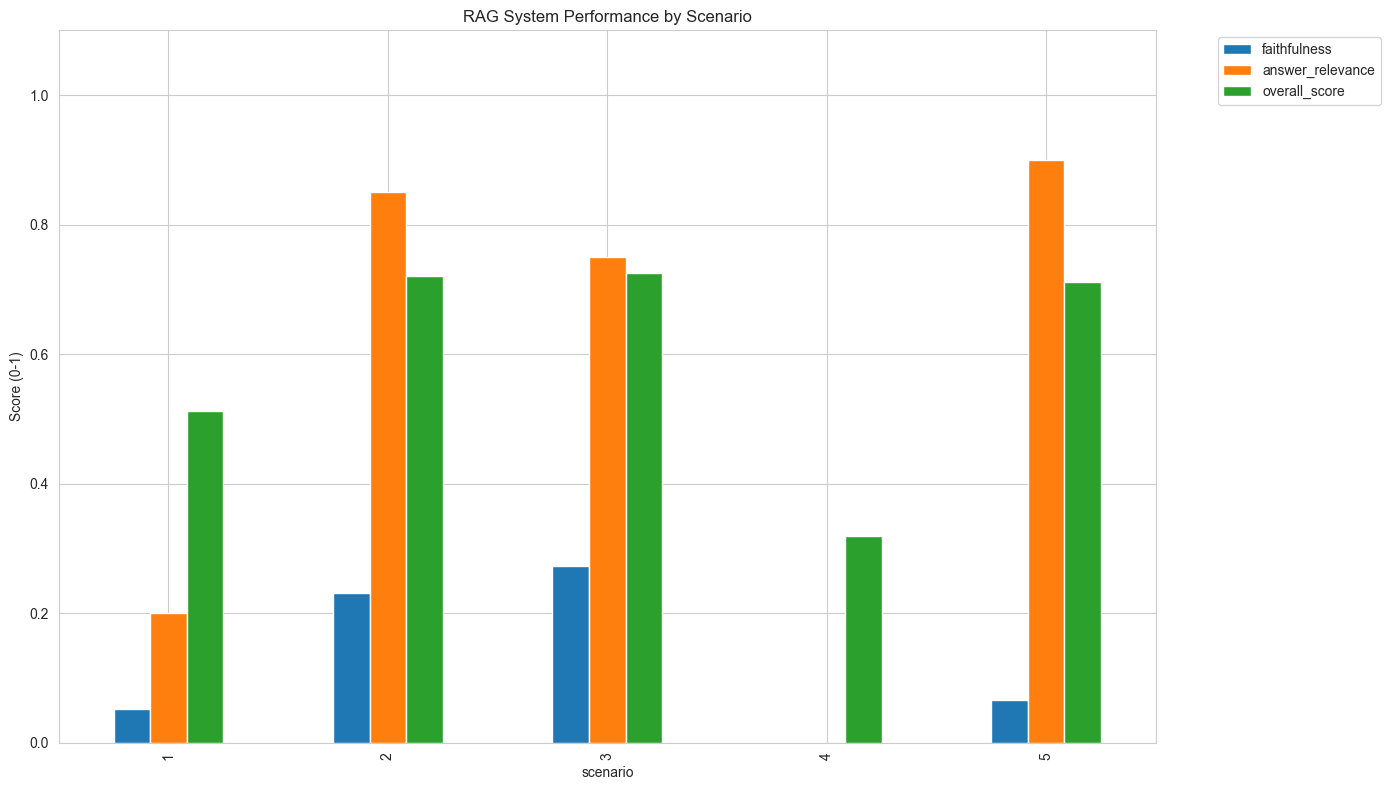

In [14]:
# Plot scores
plt.figure(figsize=(12, 6))
results_df.set_index('scenario')[['faithfulness', 'answer_relevance', 'overall_score']].plot(kind='bar')
plt.title('RAG System Performance by Scenario')
plt.ylabel('Score (0-1)')
plt.ylim(0, 1.1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()